# Build Recommender System

## Guidelines:
    1. Recommendation based on same month last year items. (CF - user based [suprise])  
    2. Recommendation based on items purchased together. (AR Mining: Apriori Alg)  
        - Find pattern on transaction histories about items bought together  
        - Market Basket Analysis
    3. Recommendation based on most often previously purchased items.  
        - For each customer_id, find top 5 frequently buys. (Content-based)  
        - Find similar items (?image recognition?)  

## Import libs

In [1]:
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import sys
import warnings
warnings.filterwarnings("ignore")

from PIL import Image

In [2]:
# Set some options for printing all the columns
np.set_printoptions(precision = 10, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.set_option('precision', 10)

pd.options.display.float_format = '{:,.7}'.format

## Read Data

In [3]:
articles     = pd.read_parquet('articles_20ss_cleaned.parquet')
customers    = pd.read_parquet('customers_20ss_cleaned.parquet')
transactions = pd.read_parquet('transactions_20ss_cleaned.parquet')   

## Recommendation #1
@ Ruoxi Ni
> 1. Filter out items that a user might like on the basis of reactions by similar users  
>> Searching a large group of people and finding a smaller set of users with tastes similar to a particular user  
>> Looks at the items they like and combines them to create a ranked list of suggestions  

In [4]:
import random
import numpy.ma as ma

In [5]:
def r1_cosine_similarity(u, v):
    return(np.dot(u, v)/np.sqrt((np.dot(u, u) * np.dot(v, v))))

In [6]:
df = customers.merge(transactions, how = 'inner', on = 'customer_id')

freq = df.groupby('customer_id').size().reset_index().rename(columns={0:'frequency'})
keep = freq[freq.frequency>30].customer_id
dff  = df[df.customer_id.isin(keep)] # filter customers with more than 30 purchases

# randomly generate ratings for customers' purchases
#r = []
#for i in range(dff.shape[0]):
#    n = random.randint(1,5)
#    r.append(n)
dff['rating'] = [random.randint(1,5) for _ in range(dff.shape[0])]

check_articles = dff.groupby('article_id').size().reset_index().\
rename(columns={0:'frequency'}).sort_values(by='frequency',ascending=False)

top_ratings = dff.iloc[check_articles[check_articles.frequency > 40].index].dropna()
top_df = top_ratings.reset_index().pivot_table(index='customer_id', columns='article_id', values='rating')

pivot = top_df.applymap(lambda x: 1 if x >= 3 else 0).to_numpy()

In [7]:
'''
If customer in filtered piviot -> eliminate row -> get similar customers
If customer in original df -> get customer's vector with same columns(1: bought/ 0: didnt buy)
@return: pivot & customer_vector
'''
def get_vector(customer):
    indices = pd.Series(top_df.index)
    
    if customer in top_df.index:
        cus_vec   = pivot[top_df.index == customer]
        new_pivot = np.delete(pivot,indices[indices == customer].index[0],0)
    else:
        new_pivot = pivot
        mask = df[df.customer_id == customer].article_id.values
        tmp = pd.DataFrame(top_df.columns)
        tmp['matched'] = tmp.article_id.apply(lambda x : 1 if x in mask else 0)
        tmp.set_index('article_id',inplace = True)
        cus_vec = tmp.T.to_numpy()

    return new_pivot,np.ravel(cus_vec)

In [28]:
# Final recommendation1
def r1(customer):
    # Compute similarity, find maximum value
    x, y = get_vector(customer)
    
    sims = np.apply_along_axis(r1_cosine_similarity, 1, x, y)
    mx = np.nanmax(sims)
    if (mx == r'^/d+') or (mx == 0):
        return None

    # Find the best matching user
    usr_idx = np.where(sims==mx)[0][0]
    # Now we subtract the vectors
    # (any negative value is a article to recommend)
    art_vec = y - x[usr_idx]

    # We want a mask aray, so we zero out any recommended article.
    art_vec[art_vec >= 0] = 1
    art_vec[art_vec < 0] = 0
    
    # Get the columns (ariticle_ids) for the current user
    art_ids = top_df[top_df.index == usr_idx].columns
    ma_art_idx = ma.array(art_ids, mask = art_vec)
    art_idx = ma_art_idx[~ma_art_idx.mask]
    art_df = articles.loc[articles.article_id.isin(art_idx)].dropna()

    #for idx,name in zip(art_df.article_id,art_df.product_group_name):
        #print(idx,name)
        #print(60*'-', end='\n\n')
    return art_df.article_id.to_list()

In [9]:
r1(6552724938240000577)

761713001 Accessories
------------------------------------------------------------

762846015 Garment Upper body
------------------------------------------------------------

808666003 Shoes
------------------------------------------------------------

815537003 Garment Lower body
------------------------------------------------------------

837439003 Garment Lower body
------------------------------------------------------------

857778002 Garment Upper body
------------------------------------------------------------

862325002 Garment Lower body
------------------------------------------------------------

865532001 Garment Full body
------------------------------------------------------------

894593001 Garment Full body
------------------------------------------------------------



[761713001,
 762846015,
 808666003,
 815537003,
 837439003,
 857778002,
 862325002,
 865532001,
 894593001]

## Recommendation #2
@ Chang Gao
> AR Mining    
> Market Basket Analysis    
> return: articles always be bought together  

In [10]:
from mlxtend.preprocessing import TransactionEncoder
from apyori import apriori 
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

In [11]:
# Helper Function for Transcation Encoding & Dataframe building
def to_df(sampled):
    ls = sampled.reset_index()['article_id'].tolist()
    te = TransactionEncoder()
    te_ary = te.fit(ls).transform(ls)
    int_type = te_ary.astype("int")
    df=pd.DataFrame(int_type, columns=te.columns_)
    return df

In [12]:
# Define helper funcation that return itemsets with support >= 0.002 
def get_itemsets(df):
    frequent_itemsets = apriori(df, min_support=0.002, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    return frequent_itemsets

In [13]:
# Helper funcation to access association rules
def get_association_rules(frequent_itemsets):
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    return rules

In [14]:
# Merge Transactions and Articles dfs by article_id
trans_info = pd.merge(transactions,articles, on = 'article_id' )
# Convert to str
trans_info['customer_id'] = trans_info['customer_id'].astype(str)
trans_info['article_id'] = trans_info['article_id'].astype(str)

In [15]:
# Grouped df by customer_id: Derive df with ine customer_id and list of purchases for each row
grouped_df = trans_info[['customer_id','article_id']].groupby('customer_id').agg({'article_id':lambda x:list(x)})

sampled1 = grouped_df['article_id'].sample(n=5000, random_state=42)
sampled2 = grouped_df['article_id'].sample(n=5000, random_state=1)
sampled3 = grouped_df['article_id'].sample(n=5000, random_state=18)
sampled4 = grouped_df['article_id'].sample(n=5000, random_state=105)
sampled5 = grouped_df['article_id'].sample(n=5000, random_state=99)
sampled6 = grouped_df['article_id'].sample(n=5000, random_state=10)
sampled7 = grouped_df['article_id'].sample(n=5000, random_state=55)
sampled8 = grouped_df['article_id'].sample(n=5000, random_state=111)
sampled9 = grouped_df['article_id'].sample(n=5000, random_state=123)
sampled10= grouped_df['article_id'].sample(n=5000, random_state=98)

df1 = to_df(sampled1)
df2 = to_df(sampled2)
df3 = to_df(sampled3)
df4 = to_df(sampled4)
df5 = to_df(sampled5)
df6 = to_df(sampled6)
df7 = to_df(sampled7)
df8 = to_df(sampled8)
df9 = to_df(sampled9)
df10= to_df(sampled10)

frequent_itemsets1 = get_itemsets(df1)
frequent_itemsets2 = get_itemsets(df2)
frequent_itemsets3 = get_itemsets(df3)
frequent_itemsets4 = get_itemsets(df4)
frequent_itemsets5 = get_itemsets(df5)
frequent_itemsets6 = get_itemsets(df6)
frequent_itemsets7 = get_itemsets(df7)
frequent_itemsets8 = get_itemsets(df8)
frequent_itemsets9 = get_itemsets(df9)
frequent_itemsets10= get_itemsets(df10)

rules1 = get_association_rules(frequent_itemsets1)
rules2 = get_association_rules(frequent_itemsets2)
rules3 = get_association_rules(frequent_itemsets3)
rules4 = get_association_rules(frequent_itemsets4)
rules5 = get_association_rules(frequent_itemsets5)
rules6 = get_association_rules(frequent_itemsets6)
rules7 = get_association_rules(frequent_itemsets7)
rules8 = get_association_rules(frequent_itemsets8)
rules9 = get_association_rules(frequent_itemsets9)
rules10= get_association_rules(frequent_itemsets10)
# Combine rules from 10 Samples together
rules = pd.concat([rules1,rules2,rules3,rules4,rules5,rules6,rules7,rules8,rules9,rules10], axis=0)
# Drop duplicates rules
rules.drop_duplicates()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.9130435,207.5099,0.00417976,11.4494
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.9545455,207.5099,0.00417976,21.8988
2,(559630026),(599580055),0.0038,0.0076,0.0024,0.6315789,83.10249,0.00237112,2.693657
3,(599580055),(559630026),0.0076,0.0038,0.0024,0.3157895,83.10249,0.00237112,1.455985
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.5806452,70.81039,0.00354916,2.365062
...,...,...,...,...,...,...,...,...,...
27,(739590031),(860949001),0.0024,0.003,0.002,0.8333333,277.7778,0.0019928,5.982
28,(823118001),(823165001),0.0032,0.0048,0.0028,0.875,182.2917,0.00278464,7.9616
29,(823165001),(823118001),0.0048,0.0032,0.0028,0.5833333,182.2917,0.00278464,2.39232
30,(841383002),(841383003),0.0072,0.0062,0.0024,0.3333333,53.76344,0.00235536,1.4907


In [16]:
def apyori_recommend(rules, transaction_df):
    ante = []
    consq = []
    antecedents = rules['antecedents'].apply(lambda x:list(x))
    consequents = rules['consequents'].apply(lambda x:list(x))
    
    for i in antecedents.values:
        string = i[0]
        num = int(string)
        ante.append(num)
    for i in consequents.values:
        string = i[0]
        num = int(string)
        consq.append(num)
    
    # Create Dictionary with antecedent as key, consquence as value
    apyori_dict = dict(zip(ante, consq))
    
    # Map transaction data with dictionary
    transactionss =  transactions[['customer_id','article_id']]
    transactionss['apyori_recomd'] = transactionss['article_id'].map(apyori_dict)
    transactionss['customer_id'] = transactionss['customer_id']
    
    #Generate groupby dataframe with each row represent a customer
    recom_grouped = transactionss.groupby('customer_id').agg({'apyori_recomd':lambda x:list(x)}).reset_index()
    #Drop nan value in recommendation column
    recom_grouped['apyori_recomd'] = recom_grouped['apyori_recomd'].apply(lambda x: [int(i) for i in x if str(i) != "nan"])
    
    return recom_grouped

In [17]:
# Final recommendation2
def r2(customer):   
    res_df = apyori_recommend(rules,transactions)
    return res_df[res_df.customer_id == customer].apyori_recomd.values[0]

In [18]:
r2(6552724938240000577)

[]

## Recommendation #3  
@ Shiyi Zheng
> Content-based   
> return: articles that are similar to another article  

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
myArticles = articles.copy()
myTransactions = transactions.sort_values(by="t_dat",ascending = False)

myArticles.product_group_name = myArticles.product_group_name.str.replace('[^a-zA-Z]', '').str.lower()
myArticles.graphical_appearance_name = myArticles.graphical_appearance_name.str.replace('[^a-zA-Z]', '').str.lower()
myArticles.perceived_colour_master_name = myArticles.perceived_colour_master_name.str.replace('[^a-zA-Z]', '').str.lower()
myArticles.index_group_name = myArticles.index_group_name.str.replace('[^a-zA-Z]', '').str.lower()
myArticles.garment_group_name = myArticles.garment_group_name.str.replace('[^a-zA-Z]', '').str.lower()

In [6]:
myArticles.set_index('article_id',inplace = True)

myArticles['bag_of_words'] = ''
for index, row in myArticles.iterrows():
    words = ''
    for col in myArticles.columns:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words
    
myArticles.drop(columns = [col for col in myArticles.columns if col!= 'bag_of_words'], inplace = True)

# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(myArticles['bag_of_words'])


# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [10]:
tmp = myTransactions.groupby('customer_id').size().reset_index().rename(columns = {0:'number of purchases'})
tmp['number of purchases'].describe()

count   727,472.0
mean      9.36463
std      11.62762
min           1.0
25%           3.0
50%           6.0
75%          12.0
max         443.0
Name: number of purchases, dtype: float64

Text(0.5, 1.0, "Distribution of customers' purchases")

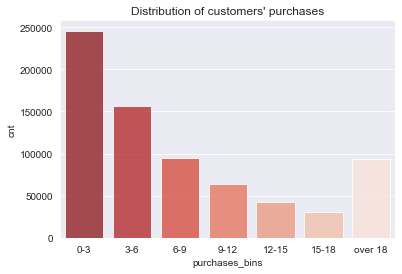

In [17]:
tmp['purchases_bins'] = pd.cut(tmp['number of purchases'],[0,3,6,9,12,15,18,500],
                       labels = ['0-3','3-6','6-9','9-12','12-15','15-18','over 18'])
vis_cus_trans = tmp.groupby('purchases_bins').size().reset_index().rename(columns = {0:'cnt'})
sns.barplot(data = vis_cus_trans,x='purchases_bins',y = 'cnt',palette = 'Reds_r',alpha = 0.8)
sns.set_style('whitegrid')
plt.title('Distribution of customers\' purchases')

In [22]:
# function that takes in article_id as input and returns the top 5 recommended movies
def cb_recommendations(article, df = myArticles, cosine_sim = cosine_sim):
    
    recommended_articles = []
    indices = pd.Series(df.index)
    # gettin the index of the movie that matches the title
    idx = indices[indices == article].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar articles
    top_5_indexes = list(score_series.iloc[1:6].index)
    
    # populating the list with the titles of the best 10 matching articles
    for i in top_5_indexes:
        recommended_articles.append(list(df.index)[i])
        
    return recommended_articles

In [23]:
# Final Recommendation3
def r3(customer):
    buys = []
    new_recommendations = []
    trans_cus = myTransactions[myTransactions.customer_id == customer]
    freq = trans_cus.groupby('article_id').size().sort_values(ascending=False).reset_index().rename(columns={0:'cnt'})
    for i in freq.article_id:
        if len(buys)<= 2:
            buys.append(i)
        else:
            break;
    for i in buys:
        new_recommendations.extend(cb_recommendations(i))
    return list(set(new_recommendations))

In [24]:
r3(6552724938240000577)

[625311008,
 831736002,
 533404002,
 678687001,
 543548008,
 862837001,
 822789003,
 533404014,
 270381007,
 564786001,
 803454001,
 740930001,
 864615001,
 742947002,
 547607005]

## Hybrid Model

In [25]:
def hybridRecommendation(customer):
    rcmd1 = r1(customer)
    #print(rcmd1)
    rcmd2 = r2(customer)
    #print(rcmd2)
    rcmd3 = r3(customer)
    #print(rcmd3)
    top10 = []
    if rcmd1 and rcmd2 and rcmd3:
        # add weights
        if len(rcmd1)<=5 and len(rcmd2)<=2:
            top10=rcmd1+rcmd2
            num = len(top10)
            top10.extend(rcmd3[:10-num])
        else:
            top10=rcmd1[:5]+rcmd2[:2]+rcmd3[:3]
    
    elif not rcmd1 and rcmd2:
        # no recommendatios from cf
        top10.extend(rcmd2)
        num=len(top10)
        top10.extend(rcmd3[:10-num])     
    
    elif not rcmd2 and rcmd1:
        # no recommendations from apriori
        if len(rcmd1)<=5:
            top10.extend(rcmd1)
            num=len(top10)
            top10.extend(rcmd3[:10-num])
        else:
            top10=rcmd1[:5]+rcmd3[:5] 
        
    elif not rcmd1 and not rcmd2:
        # all from content-based
        return rcmd3[:10]
    return top10

In [26]:
cus = 6552724938240000577
top10 = hybridRecommendation(cus)

761713001 Accessories
------------------------------------------------------------

762846015 Garment Upper body
------------------------------------------------------------

808666003 Shoes
------------------------------------------------------------

815537003 Garment Lower body
------------------------------------------------------------

837439003 Garment Lower body
------------------------------------------------------------

857778002 Garment Upper body
------------------------------------------------------------

862325002 Garment Lower body
------------------------------------------------------------

865532001 Garment Full body
------------------------------------------------------------

894593001 Garment Full body
------------------------------------------------------------



## Visualization

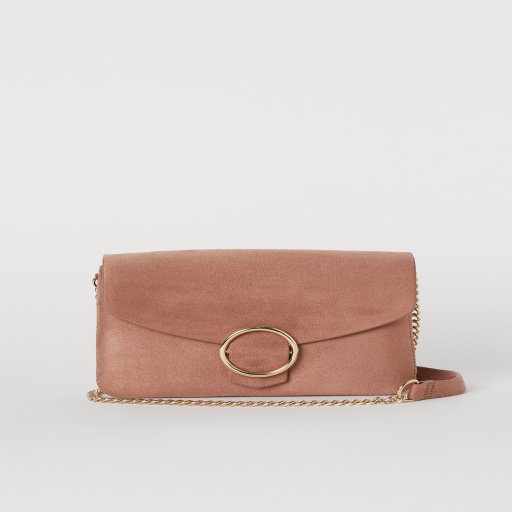

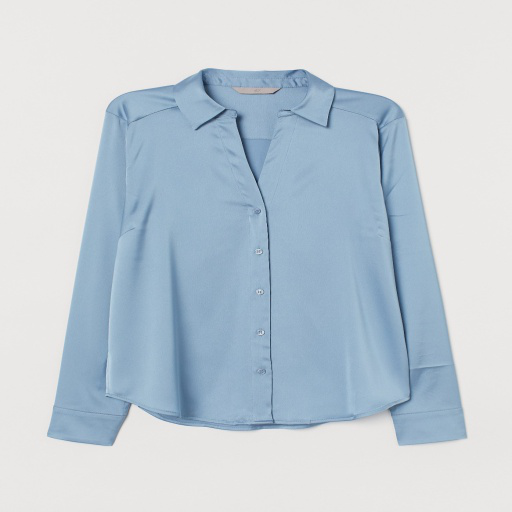

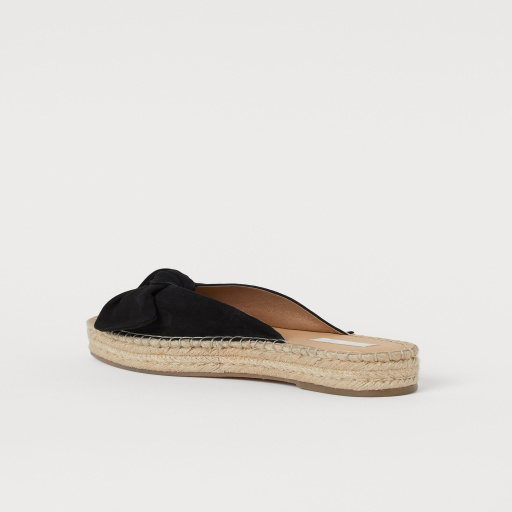

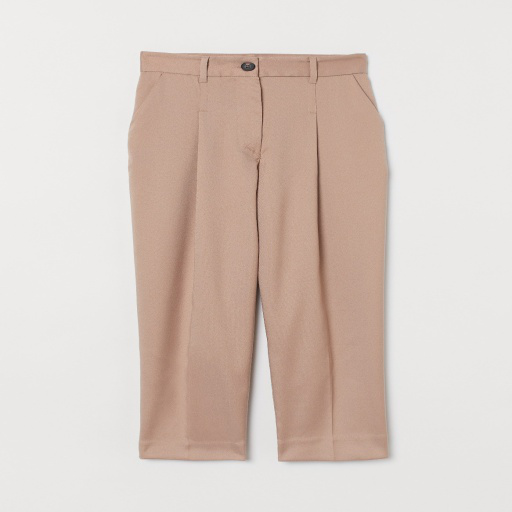

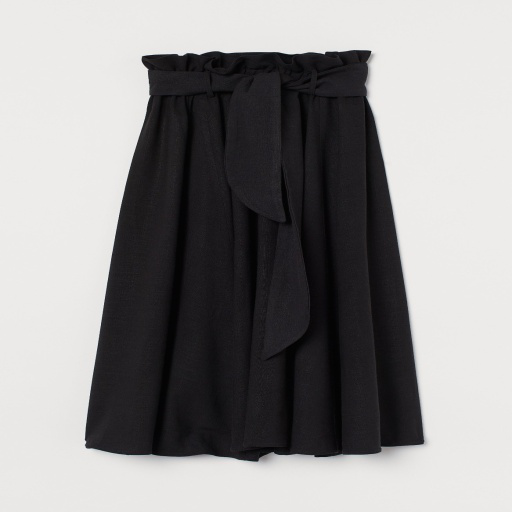

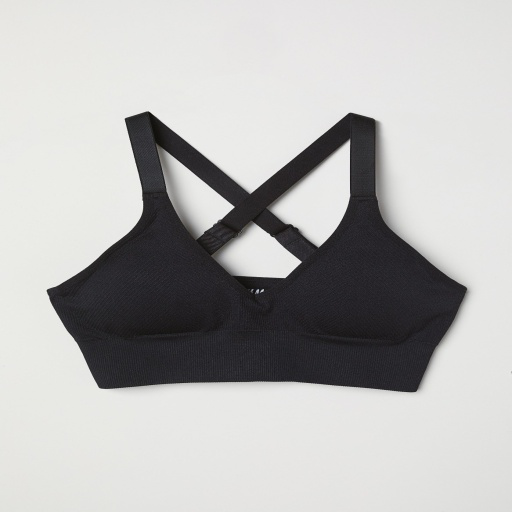

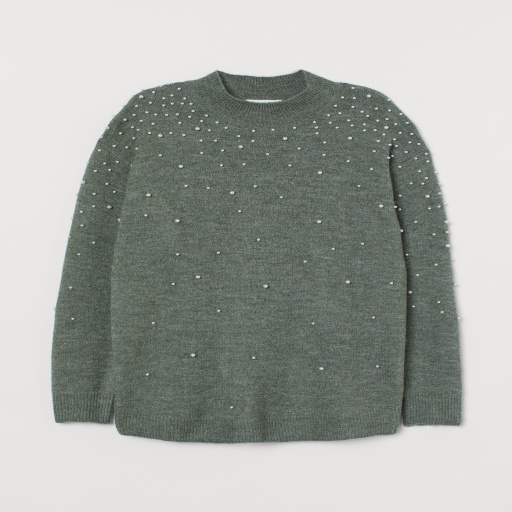

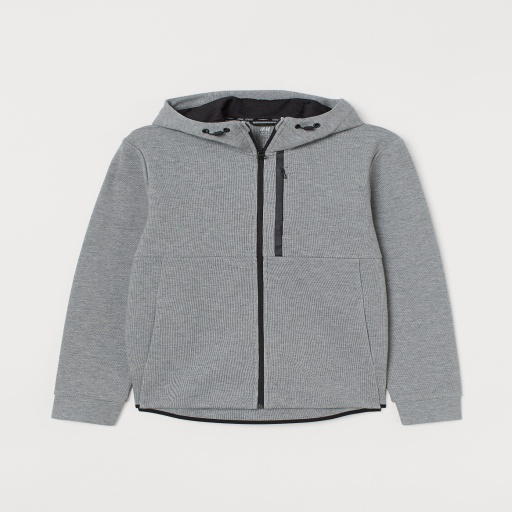

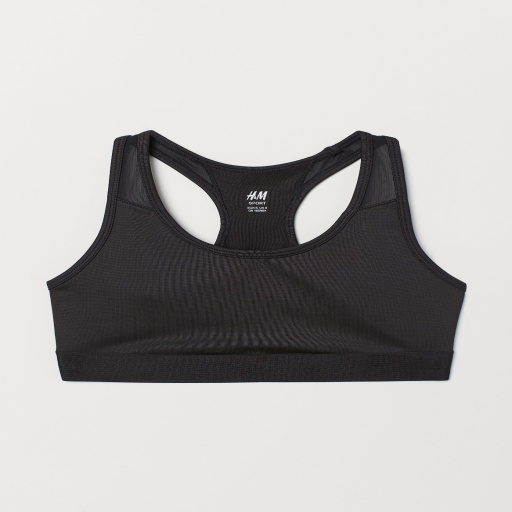

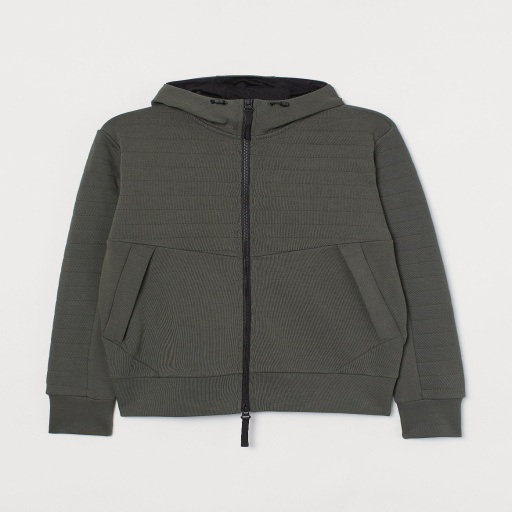

In [27]:
recommendations = ['0'+ str(i) for i in top10]

for i in recommendations:
    idx = i[:3]
    directory = 'images_512_512/'+idx+'/'+i+'.jpg'
    img = Image.open(directory)
    display(img)

## UI

In [30]:
!jupyter nbextension enable --py widgetsnbextension
import ipywidgets as widgets

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [47]:
dropdown_candidates = widgets.Dropdown(options = customers.customer_id[:11])
img_recommendations = widgets.Output()

def dropdown_candidates_display(change):
    #img_recommendations.clear_output()
    #with img_recommendations:
    recommendations = ['0'+ str(i) for i in hybridRecommendation(change.new)]
    for i in recommendations: 
        display(Image.open('images_512_512/'+i[:3]+'/'+i+'.jpg'))
        
dropdown_candidates.observe(dropdown_candidates_display,names = 'value')
display(dropdown_candidates)

Dropdown(options=(6883939031699146327, -7200416642310594310, -6846340800584936, -283965518499174310, -83346317…